# Excercise 4
Authors: Moro Palma Loris, Vedasri Nakka, Mirko Bristle, Alexandra Kovacs, Michael Brunner

Deadline: May 30, 2021 (end of day)




In [9]:
import os
import xml.etree.ElementTree as ET
import pandas as pd


def get_graph_list(path, type):
    activity_df = pd.read_csv(type + ".txt", sep=" ", header=None)

    graph_list = list()
    for idx in activity_df.index:

        tree = ET.parse(path + str(activity_df[0][idx]) + ".gxl")
        node_list = list()
        for node in tree.findall(".//node"):
            node_attr = node.findall(".//attr/")
            node_list.append(
                {
                    "id": node.attrib['id'],
                    "symbol": str(node_attr[0].text),
                    "chem": int(node_attr[1].text),
                    "charge": int(node_attr[2].text),
                    "x": float(node_attr[3].text),
                    "y": float(node_attr[4].text),
                }
            )

        edge_list = list()
        for edge in tree.findall(".//edge"):
            edge_list.append({
                'start': edge.get('from'),
                'end': edge.get('to'),
                'valence': int(edge.find(".//attr/").text)
            })
        graph_list.append({
            "id": activity_df[0][idx],
            "activity": activity_df[1][idx],
            "nodes": node_list,
            "edges": edge_list
        })
    return graph_list


train_graphs = get_graph_list("gxl/", "train")
valid_graphs = get_graph_list("gxl/", "valid")


In [10]:
import numpy as np


# get the representation of graph: list of nodes T(<label: string>,<number of edges of the node: int>)

def get_dirac_feature_labels(graph_list):
    dirac_graph_feature_list = list()
    dirac_graph_label_list = list()
    for graph in graph_list:
        dirac_node_list = list()
        for node in graph['nodes']:
            num_nodes = np.sum([1 if node['id'] in [edge['start'], edge['end']] else 0 for edge in graph['edges']])
            dirac_node_list.append([
                node['symbol'],
                num_nodes
            ])
        dirac_graph_feature_list.append(np.asarray(dirac_node_list))
        # do some binary encoding
        dirac_graph_label_list.append(0 if graph['activity'] == 'i' else 1)
    return dirac_graph_feature_list, dirac_graph_label_list


train_x, train_y = get_dirac_feature_labels(train_graphs)
test_x, test_y = get_dirac_feature_labels(valid_graphs)


In [11]:
from dirac import hungarian_metric
from scipy import stats


def get_neighbors(test_x_i, test_y_i, train_x, train_y):
    distance = np.asarray([hungarian_metric(i, test_x_i) for i in train_x])
    dist_labels = np.stack((distance, np.asarray(train_y)), axis=1)
    dist_labels = dist_labels[np.argsort(dist_labels[:, 0])]

    return dist_labels[:, 1]


# kNN Algorithm
def k_nearest_neighbors(train_x, train_y, test_x, test_y):
    neighbors = [get_neighbors(test_x[t], test_y[t], train_x, train_y) for t in range(len(test_y))]
    return neighbors


def get_mode(neighbors, k):
    return stats.mode(neighbors[0:k]).mode[0]


neighbors_list = k_nearest_neighbors(train_x, train_y, test_x, test_y)

out = pd.DataFrame(columns=['K', 'Accuracy'])

for k in [1, 3, 5, 10, 15, 20, 30, 40, 50]:
    predictions = [get_mode(neighbors, k) for neighbors in neighbors_list]
    acc = np.mean(np.equal(np.asarray(test_y, dtype=bool), np.asarray(predictions, dtype=bool)))
    out = out.append({
        'K': k,
        'Accuracy': acc},
        ignore_index=True)


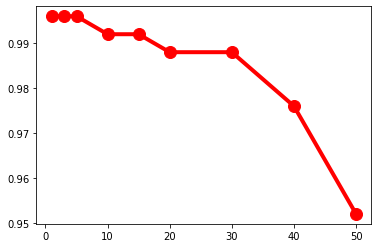

,K,Accuracy
0,1.0,0.996
1,3.0,0.996
2,5.0,0.996
3,10.0,0.992
4,15.0,0.992
5,20.0,0.988
6,30.0,0.988
7,40.0,0.976
8,50.0,0.952


In [12]:
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

plt.plot('K', 'Accuracy', data=out, marker='o', markerfacecolor='r', markersize=12, color='r', linewidth=4)
plt.show()
display(out)